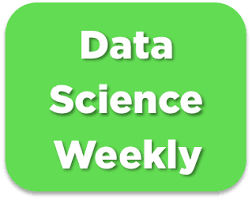

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [10]:
data.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [15]:
data.isna().sum() # As we can see in the describe(), it's no NaN values

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


The target is "converted". We have to do a binary classification. Numerical features will be age and total_pages_visited. And categorical features will be country', new_user  and source

In [5]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

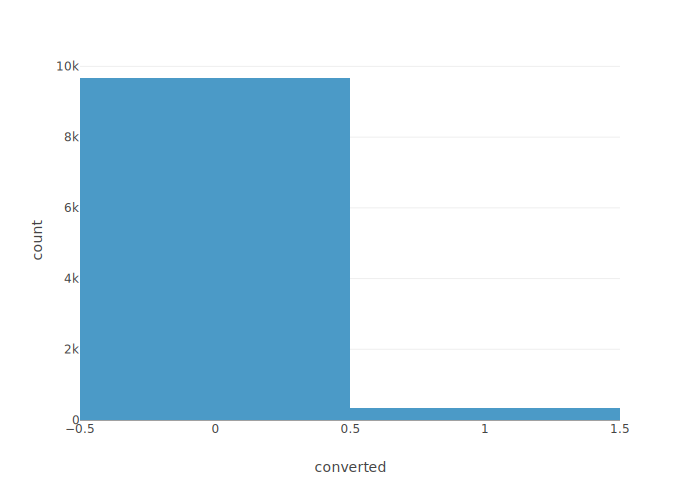

In [18]:
fig = px.histogram(data_sample, x='converted')
fig.show()

The target looks very unbalanced!

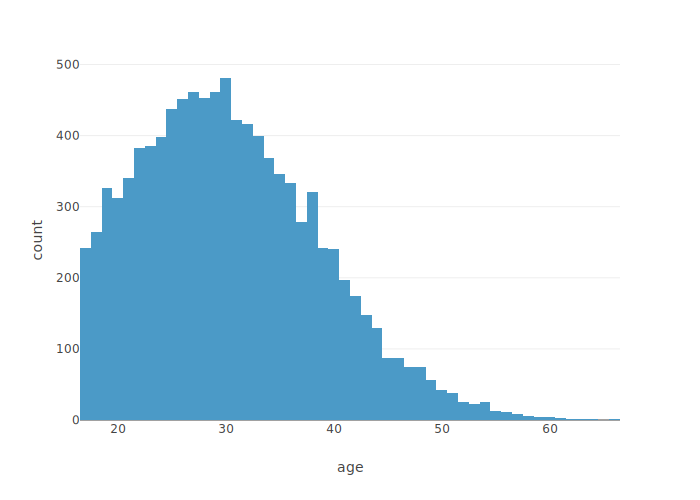

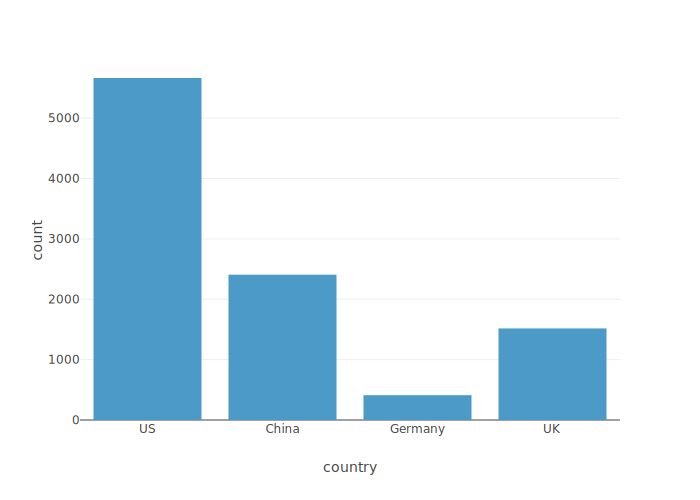

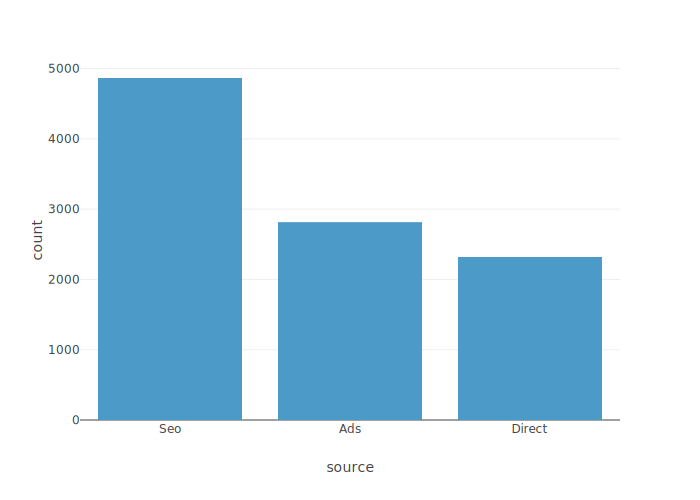

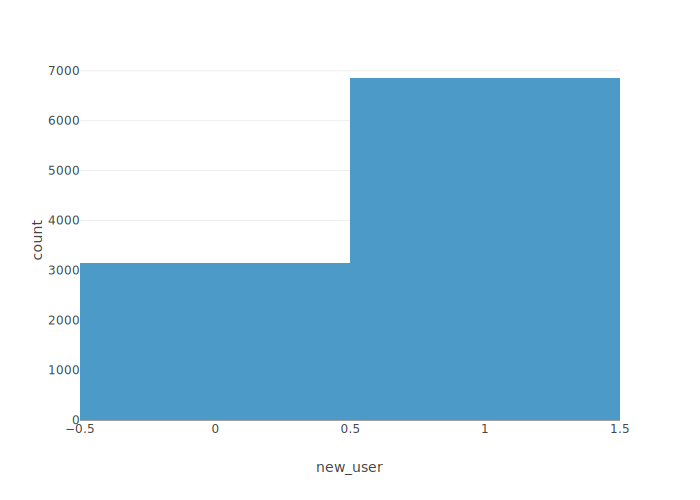

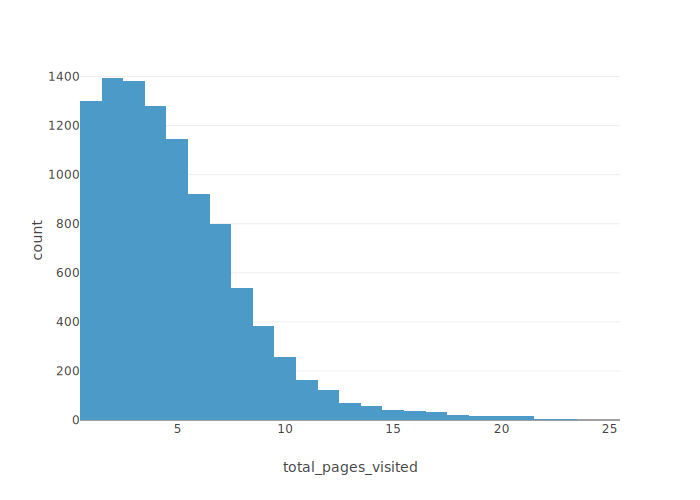

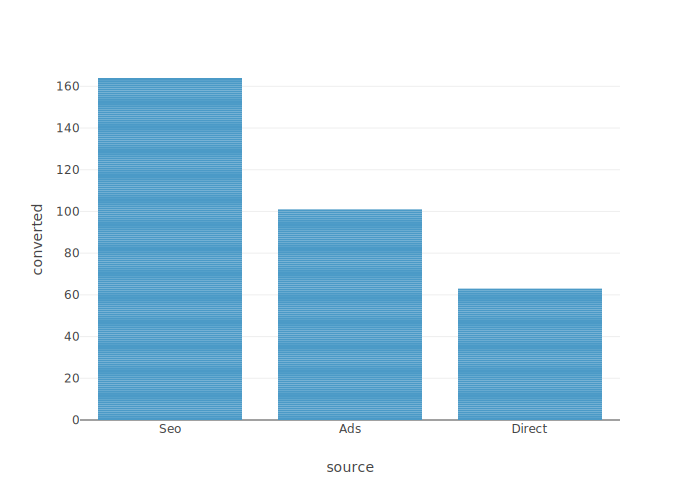

In [7]:
fig = px.histogram(data_sample, x='age')
fig.show()
fig = px.histogram(data_sample, x='country')
fig.show()
fig = px.histogram(data_sample, x='source')
fig.show()
fig = px.histogram(data_sample, x='new_user')
fig.show()
fig = px.histogram(data_sample, x='total_pages_visited')
fig.show()

fig = px.bar(data_sample, x='source', y='converted')
fig.show()

We can see some unbalance classes, like the Country. US is huge and Germany has a much smaller amount of data.

Distribution of numerical features are a normal distribution.

For all features, it doesn't look it's illogical values like a age of 200 years of a negative number of pages visited.

**The dataset looks clean.**

# Make your model

## Choose variables to use in the model, and create train and test sets

In [16]:
numerical_features = ['age','total_pages_visited']
categorical_features = ['country','new_user','source']
target_variable = 'converted'

In [17]:
X = data.drop('converted', axis=1)
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [30]:
# Divide dataset Train set & Test set.
# With Stratify=Y, we manage the unbalanced target class to be better balanced on test and train sets
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Baseline pipeline: preprocessing, train and test

In [31]:
# Preprocessing
# No need to manage empty values becore it's no NaN in the dataset
print("Encoding categorical features and standardizing numerical features...")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Encoding categorical features and standardizing numerical features...


In [43]:
# utilities to save scores in df_scores DataFrame
df_scores = pd.DataFrame(columns=['title', 'F1 train', 'F1 test', 'params'])
def save_score(title, score_train, score_test, params, verbose=True):
    global df_scores
    if verbose:
        print('Model:', title)
        print('F1 score on Train:', score_train)
        print('F1 score on Test:', score_test)
        print('Best hyper parameters:', str(params))
    dic_score = {'title': title, 'F1 train': score_train, 'F1 test': score_test, 'params': str(params)}
    df_scores = pd.concat([df_scores,pd.DataFrame(dic_score, index=[df_scores.shape[0]])], axis=0)

In [100]:
# Baseline Model
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)

save_score('Baseline - LogisticRegression', f1_score(Y_train, Y_train_pred), f1_score(Y_test, Y_test_pred), 'N/A')

Model: Baseline - LogisticRegression
F1 score on Train: 0.7640283915896611
F1 score on Test: 0.7595396729254997
Best hyper parameters: N/A


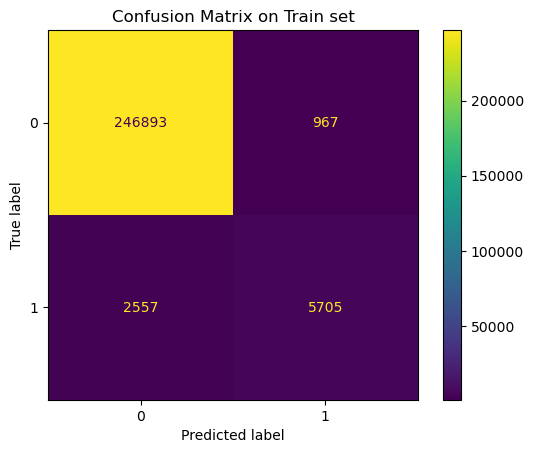

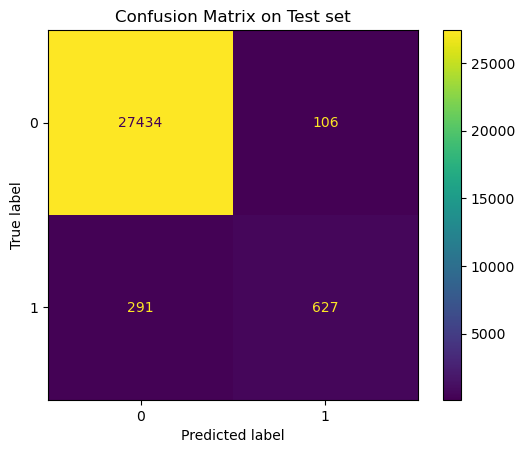

In [98]:
# You can also check more performance metrics to better understand what your model is doing
from sklearn.metrics import ConfusionMatrixDisplay

_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Train set")
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax)

_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax)

We see that the most mistakes are false negative (291 in Test set). That's mean, the model predicts the user will not convert and he finally convert. We have some false positive (106): that's mean that the model predicts the user will convert and didn't in real.

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Better models than Baseline?

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, BaggingRegressor,\
StackingRegressor, RandomForestRegressor, StackingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [61]:
# Ridge ?
params = {
    'alpha': [0.001, 0.005,0.01, 0.03, 0.05, 1, 10],
    'max_iter': [20, 50, 100, 200],
    'class_weight': ['balanced', None]
}
model = GridSearchCV(RidgeClassifier(), param_grid = params, scoring='f1', n_jobs=-1, cv=5, verbose=0)
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)


save_score('GS - RidgeClassifier', f1_score(Y_train, Y_train_pred), f1_score(Y_test, Y_test_pred), model.best_params_)

Model: GS - RidgeClassifier
F1 score on Train: 0.5503775620280474
F1 score on Test: 0.5465717981888745
Best hyper parameters: {'alpha': 0.001, 'class_weight': 'balanced', 'max_iter': 20}


In [68]:
# SVC ?
params = {
    # 'C': [8, 10, 20, 30],
    # 'gamma': [0.1, 0.3, 0.5, 0.8, 1],
    # 'kernel': ['rbf'],
    'C': [10],
    'gamma': [0.5],
    # 'class_weight': ['balanced', None]
}
model = GridSearchCV(SVC(probability=True), param_grid = params, scoring='f1', n_jobs=-1, cv=5, verbose=2)
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)


save_score('GS - SVC', f1_score(Y_train, Y_train_pred), f1_score(Y_test, Y_test_pred), model.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....................................C=10, gamma=0.5; total time=19.6min
[CV] END ....................................C=10, gamma=0.5; total time=20.1min
[CV] END ....................................C=10, gamma=0.5; total time=20.3min
[CV] END ....................................C=10, gamma=0.5; total time=25.7min
[CV] END ....................................C=10, gamma=0.5; total time=26.9min
Model: GS - SVC
F1 score on Train: 0.762544073772715
F1 score on Test: 0.7539585870889159
Best hyper parameters: {'C': 10, 'gamma': 0.5}


In [70]:
# RandomForest ?
params = {
    'n_estimators': [30, 50, 100],
    'max_depth': [10, 30, 50],
    'min_samples_split': [10, 50, 250, ],
    'min_samples_leaf': [5, 20, 30, 40],
    'class_weight': ['balanced', None],
    'criterion': ['entropy']

}
model = GridSearchCV(RandomForestClassifier(), param_grid = params, scoring='f1', n_jobs=-1, cv=5, verbose=0)
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)


save_score('GS - RandomForest', f1_score(Y_train, Y_train_pred), f1_score(Y_test, Y_test_pred), model.best_params_)

Model: GS - RandomForest
F1 score on Train: 0.7647098109931209
F1 score on Test: 0.7536057692307693
Best hyper parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 250, 'n_estimators': 100}


In [95]:
# XGBoost ?
import xgboost as xgb
# to limit the calculation time of this notebook, I let only the best paramaters I found in my working notebook.
params = { # winner
    'max_depth': [4], #good
    'n_estimators': [73],
    'learning_rate':  [0.135],
    'min_child_weight': [1],
    'gamma':[4.915], # good
    #'subsample':[0.95, 0.97, 0.99, 1], good
    #'lambda': [0.98,1,1.02], good
    'objective': ['binary:logistic'],
    'scale_pos_weight': [1.52], # good
    'eval_metric':['rmse']
}

xgb_classifier = xgb.XGBClassifier(n_jobs=-1, objective= 'binary:logistic', nthread=4, seed=42)
model_xgb = GridSearchCV(xgb_classifier, param_grid = params, scoring='f1', n_jobs=-1, cv=5, verbose=2)
model_xgb.fit(X_train, Y_train)

Y_train_pred = model_xgb.predict(X_train)
Y_test_pred = model_xgb.predict(X_test)

save_score('GS - XGBoost', f1_score(Y_train, Y_train_pred), f1_score(Y_test, Y_test_pred), model_xgb.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=   2.6s
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=   2.7s
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=   2.7s
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=   2.6s
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=   2.7s
Model: GS - XGBoost
F1 score on Train: 0.

In [83]:
# LightGBM ?
import lightgbm as lgbm
params = {
    'max_depth': [2, 3, 5], 
    'n_estimators': [150, 220, 350],
    'learning_rate':  [0.05, 0.1],
    'scale_pos_weight': [1, 1.55, 2],
    'min_split_gain': [0.27, 0.30],
    'num_leaves': [4, 5, 6],
    'min_child_weight':[0.0001],
    'subsample_for_bin': [150000],
}

model = GridSearchCV(lgbm.LGBMClassifier(n_jobs=-1, objective='binary', seed=42), param_grid = params, scoring='f1', n_jobs=-1, cv=5, verbose=2)
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

save_score('GS - LightGBM', f1_score(Y_train, Y_train_pred), f1_score(Y_test, Y_test_pred), model.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END learning_rate=0.05, max_depth=2, min_child_weight=0.0001, min_split_gain=0.27, n_estimators=150, num_leaves=4, scale_pos_weight=1, subsample_for_bin=150000; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=2, min_child_weight=0.0001, min_split_gain=0.27, n_estimators=150, num_leaves=4, scale_pos_weight=1, subsample_for_bin=150000; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=2, min_child_weight=0.0001, min_split_gain=0.27, n_estimators=150, num_leaves=4, scale_pos_weight=1.55, subsample_for_bin=150000; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=2, min_child_weight=0.0001, min_split_gain=0.27, n_estimators=150, num_leaves=4, scale_pos_weight=1.55, subsample_for_bin=150000; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=2, min_child_weight=0.0001, min_split_gain=0.27, n_estimators=150, num_leaves=4, scale_pos_weight=1, subsample_for_bin=150000; total time=   1.0s
[CV] 

## What is the best model?

In [104]:
df_scores.sort_values('F1 test', ascending=False)

,title,F1 train,F1 test,params
3,GS - XGBoost,0.772890,0.761795,"{'eval_metric': 'rmse', 'gamma': 4.915, 'learn..."
5,Baseline - LogisticRegression,0.764028,0.759540,N/A
4,GS - LightGBM,0.771786,0.759091,"{'learning_rate': 0.1, 'max_depth': 2, 'min_ch..."
1,GS - SVC,0.762544,0.753959,"{'C': 10, 'gamma': 0.5}"
2,GS - RandomForest,0.764710,0.753606,"{'class_weight': None, 'criterion': 'entropy',..."
0,GS - RidgeClassifier,0.550378,0.546572,"{'alpha': 0.001, 'class_weight': 'balanced', '..."


In [106]:
print("Standard deviation is:", model_xgb.cv_results_['std_test_score'][model_xgb.best_index_])

Standard deviation is: 0.00700750502907136


XGBoost looks the best! But the LogisticRegression has a very good results with less overfitting.

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

Because I used the same var name for the model ("model"), I'll need to declare again the model. I use the Gridsearch with best hyperparams to simply. I keep the same seed at 42. **And I fit with ALL data X, Y**

In [96]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

model_xgb.fit(X, Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=   2.8s
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=   3.0s
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=   2.9s
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=   2.9s
[CV] END eval_metric=rmse, gamma=4.915, learning_rate=0.135, max_depth=4, min_child_weight=1, n_estimators=73, objective=binary:logistic, scale_pos_weight=1.52; total time=   2.9s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=-1,
             param_grid={'eval_metric': ['rmse'], 'gamma': [4.915],
                         'learning_rate': [0.135], 'max_depth': [4],
                         'min_child_weight': [1], 'n_estimators': [73],
                         'objective': ['binary:logistic'],
                         'scale_pos_weight': [1.52]},
             scoring='f1', verbose=2)

In [107]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
# features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, :] # keep all columns

Prediction set (without labels) : (31620, 5)


In [108]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.30994956  3.32882805  0.          1.          0.          0.
   0.          1.        ]
 [-1.03550673  0.03808136  0.          1.          0.          1.
   1.          0.        ]
 [ 0.17375521 -1.1585538   0.          0.          0.          1.
   0.          1.        ]
 [ 0.17375521  0.33724015  0.          0.          1.          1.
   0.          0.        ]
 [-0.67272814 -0.56023622  0.          0.          0.          0.
   0.          1.        ]]


In [112]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': model_xgb.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_JULIEN-model1.csv', index=False)


Luckely, my model was the winner model of the contest:

# 🥳

<img src="results.png" />